In [1]:
from src import models, dataset, losses, utils
import segmentation_models_pytorch as smp
import torch
import os
import numpy as np
import albumentations as A
import multiprocessing as mp

from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2

import time
from tqdm import tqdm

In [2]:
utils.seed_everything(42)

main_path = '.'
data_path = os.path.join(main_path, 'input', 'data')

mean = np.array([0.46098186, 0.44022841, 0.41892368], dtype=np.float32)
std  = np.array([0.21072529, 0.20763867, 0.21613272], dtype=np.float32)

In [3]:
model = smp.DeepLabV3Plus(
            encoder_name="efficientnet-b3",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights="imagenet",
            in_channels=3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=12,  # model output channels (number of classes in your dataset)
        )
model.load_state_dict(torch.load("/opt/ml/p3-ims-obd-multihead_ensemble/segmentation/ckpts/effib3_deeplabv3+/best_mIoU.pth"))

<All keys matched successfully>

In [56]:
val_tfms = A.Compose([
        A.Resize(256, 256),
        #A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.Normalize(),
        ToTensorV2(transpose_mask=True)
    ])

trn_annot = os.path.join(data_path, 'train.json')
val_annot = os.path.join(data_path, 'val.json')
trn_cat = utils.make_cat_df(trn_annot, debug=True)
val_cat = utils.make_cat_df(val_annot, debug=True)

trn_ds = dataset.SegmentationDataset(data_dir=trn_annot, cat_df=trn_cat, mode='train', transform=val_tfms, binary_mask=True)
val_ds = dataset.SegmentationDataset(data_dir=val_annot, cat_df=val_cat, mode='valid', transform=val_tfms, binary_mask=True)

Number of super categories: 11
Number of categories: 11
Number of annotations: 21116
Number of images: 2617

Number of super categories: 11
Number of categories: 11
Number of annotations: 5284
Number of images: 655

loading annotations into memory...
Done (t=3.58s)
creating index...
index created!
loading annotations into memory...
Done (t=0.77s)
creating index...
index created!


In [57]:
val_dl = DataLoader(dataset=val_ds,
                        batch_size=16,
                        shuffle=False,
                        num_workers=3)

trn_dl = DataLoader(dataset=trn_ds,
                        batch_size=4,
                        shuffle=True,
                        num_workers=3)



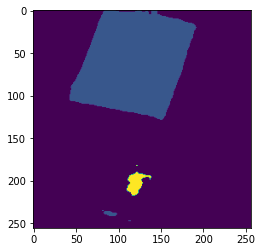

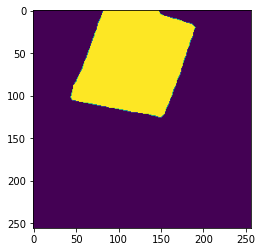

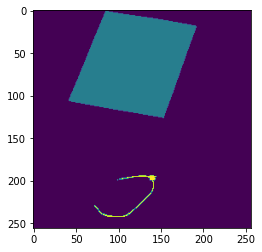

In [58]:
model.to("cpu")

for batch, sample in enumerate(val_dl):
    images, masks = sample['image'].float(), sample['mask']
    prds = model(images)
    if batch == 0:
        break
        
        
idx=1
prds = torch.sigmoid(prds)

plt.imshow(prds[idx].argmax(0))        
plt.show()        
probs = np.array(utils.dense_crf_wrapper((images[idx].numpy().astype(np.uint8).transpose(1,2,0), prds.detach().numpy()[idx])))
plt.imshow(probs.argmax(0))
plt.show()
plt.imshow(masks[idx].argmax(dim=0).numpy())

In [93]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)
model.eval()
val_mIoU = []
val_losses = []
n_class = 12
hist = np.zeros((n_class, n_class))
epoch=0
prob_sum = torch.zeros(12)
correct_sum = torch.zeros(12)
TP_count = torch.zeros(12)
TP_probs = torch.zeros(12)
soft_TP_probs = torch.zeros(12)
with torch.no_grad():
    with tqdm(val_dl, total=len(val_dl), unit='batch') as val_bar:
        for batch, sample in enumerate(val_bar):
            val_bar.set_description(f"Valid Epoch {epoch+1}")

            images, masks = sample['image'], sample['mask']
            images, masks = images.to(device), masks.to(device)
            preds = model(images)
            
            
            prob_sum += torch.sigmoid(preds).sum(axis=3).sum(axis=2).sum(axis=0).cpu()
            
            correct_prob = torch.sigmoid(preds)*masks
            correct_sum += correct_prob.sum(axis=3).sum(axis=2).sum(axis=0).cpu()
            
            soft_preds = torch.nn.functional.softmax(preds,dim=1).cpu()
            preds = torch.sigmoid(preds).cpu()
            
            week_preds_indice = soft_preds.max(dim=1,)[0] < 0.5
            preds = preds*weights.reshape(1,12,1,1)
            
            masks = masks.detach().cpu()
            max_mask = torch.eye(12)[preds.argmax(dim=1)].transpose(3,1).transpose(2,3)         
            answer_probs = preds*max_mask*masks 
            answer_soft_probs = soft_preds*max_mask*masks
            
            TP_probs += answer_probs.sum(axis=3).sum(axis=2).sum(axis=0)
            soft_TP_probs += answer_soft_probs.sum(axis=3).sum(axis=2).sum(axis=0)
                                    
            preds = torch.argmax(preds,dim=1)
            masks = masks.argmax(dim=1)
            max_mask = torch.eye(12)[preds].transpose(3,1).transpose(2,3)
            TP_count += np.bincount(preds[(preds==masks)],minlength=12)
                        
            hist = utils.add_hist(hist, masks.numpy(), preds.numpy(), n_class=n_class)

            val_bar.set_postfix(val_loss=np.mean(val_losses),
                                val_mIoU=np.mean(val_mIoU))

    acc, acc_cls, val_mIoU, fwavacc = utils.label_accuracy_score(hist)
    print(f'Valid Epoch {epoch+1} ==>  Batch [{str(batch+1).zfill(len(str(len(val_dl))))}/{len(val_dl)}]  |  Loss: {np.mean(val_losses):.5f}  |  mIoU: {val_mIoU:.5f}')

Valid Epoch 1:   0%|          | 0/41 [00:00<?, ?batch/s]/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Valid Epoch 1: 100%|██████████| 41/41 [03:06<00:00,  4.55s/batch, val_loss=nan, val_mIoU=nan]

Valid Epoch 1 ==>  Batch [41/41]  |  Loss: nan  |  mIoU: 0.48559


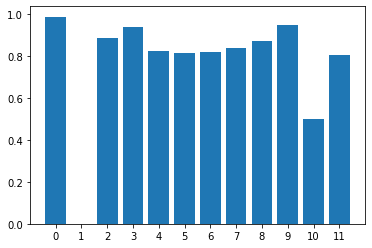

In [90]:
plt.bar(np.array(range(0,12)),(TP_probs/TP_count).numpy())
plt.xticks(np.array(range(0,12)), np.array(range(0,12)))
plt.show()

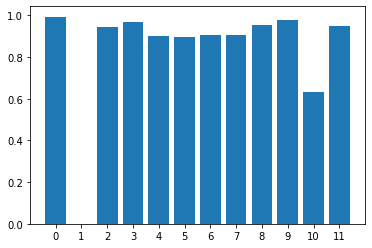

In [53]:
plt.bar(np.array(range(0,12)),(soft_TP_probs/TP_count).numpy())
plt.xticks(np.array(range(0,12)), np.array(range(0,12)))
plt.show()

In [ ]:
plt.bar(np.array(range(0,12)),(TP_probs/TP_count).numpy())
plt.xticks(np.array(range(0,12)), np.array(range(0,12)))
plt.show()

In [9]:
a = torch.zeros(12)

for i in range(len(trn_ds)):
    a += trn_ds[i]['mask'].sum(axis=1).sum(axis=1)

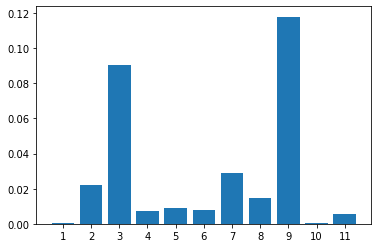

In [10]:
no_back_a = a[1:]
plt.bar(np.array(range(1,12)),(no_back_a/a.sum()).numpy())
plt.xticks(np.array(range(1,12)), np.array(range(1,12)))
plt.show()

In [11]:
b = torch.zeros(12)
for i in range(len(val_ds)):
    b += val_ds[i]['mask'].sum(axis=1).sum(axis=1)

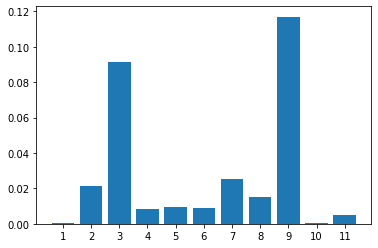

In [12]:
plt.bar(np.array(range(1,12)),(b/b.sum())[1:].numpy())
plt.xticks(np.array(range(1,12)), np.array(range(1,12)))
plt.show()

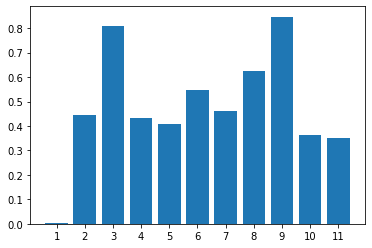

In [13]:
plt.bar(np.array(range(1,12)),(correct_sum/b)[1:])
plt.xticks(np.array(range(1,12)), np.array(range(1,12)))
plt.show()

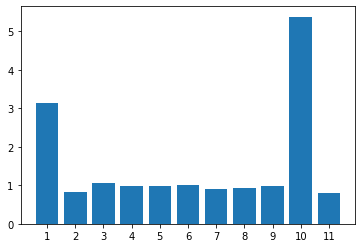

In [14]:
plt.bar(np.array(range(1,12)),((prob_sum/b)[1:].numpy()))
plt.xticks(np.array(range(1,12)), np.array(range(1,12)))
plt.show()

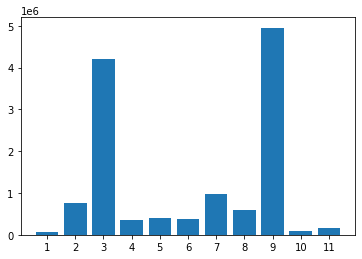

In [15]:
plt.bar(np.array(range(1,12)),(prob_sum[1:].numpy()))
plt.xticks(np.array(range(1,12)), np.array(range(1,12)))
plt.show()

In [82]:
TP_probs/TP_count

tensor([0.9860,    nan, 0.8865, 0.9353, 0.8205, 0.8113, 0.8167, 0.8393, 0.8696,
        0.9468, 0.5008, 0.8022], dtype=torch.float64)

In [92]:
we = 1/(correct_sum/b)
we = we+5
weights = we/we.sum()
weights

tensor([0.0092, 0.8827, 0.0111, 0.0095, 0.0112, 0.0114, 0.0105, 0.0110, 0.0101,
        0.0095, 0.0119, 0.0120])

In [20]:
train_freq = 1/a
train_freq/train_freq.sum()

tensor([3.1898e-04, 3.5551e-01, 9.9899e-03, 2.4553e-03, 3.1568e-02, 2.4903e-02,
        2.9091e-02, 7.7181e-03, 1.4856e-02, 1.8810e-03, 4.8005e-01, 4.1651e-02])

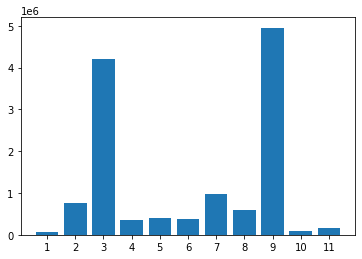

In [21]:
plt.bar(np.array(range(1,12)),(prob_sum[1:]).numpy())
plt.xticks(np.array(range(1,12)), np.array(range(1,12)))
plt.show()